In [66]:
# Importing all the required libraries
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [67]:
import tensorflow as tf # Importing tensorflow

In [68]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  # INPUT_SIZE = 1024
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    # target_size = (width, height)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [69]:
import os
import tempfile
import urllib.request
import tensorflow as tf

# Your model-related constants
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    # ... (other model URLs)
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

# Create a temporary directory for downloading and extracting the model
model_dir = tempfile.mkdtemp()
os.makedirs(model_dir, exist_ok=True)

# Download the model tarball
download_path = os.path.join(model_dir, _TARBALL_NAME)
print('Downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('Download completed! Loading DeepLab model...')

# Assuming you have the DeepLabModel class defined elsewhere in your code
class DeepLab:
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break

        self.graph = tf.Graph()
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from the original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * DeepLabModel.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            DeepLabModel.OUTPUT_TENSOR_NAME,
            feed_dict={DeepLabModel.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

# Rest of your code...


MODEL = DeepLab(download_path)
print('Model loaded successfully!')

Download completed! Loading DeepLab model...
Model loaded successfully!


In [70]:
# Creating a function which will call the method run from previously define class.
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

In [71]:
from google.colab import drive

drive.mount('/content/drive')
IMAGE_NAME = '/content/drive/MyDrive/family_image.jpg'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


running deeplab on image


<ipython-input-69-9e1dfe554822>:57: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


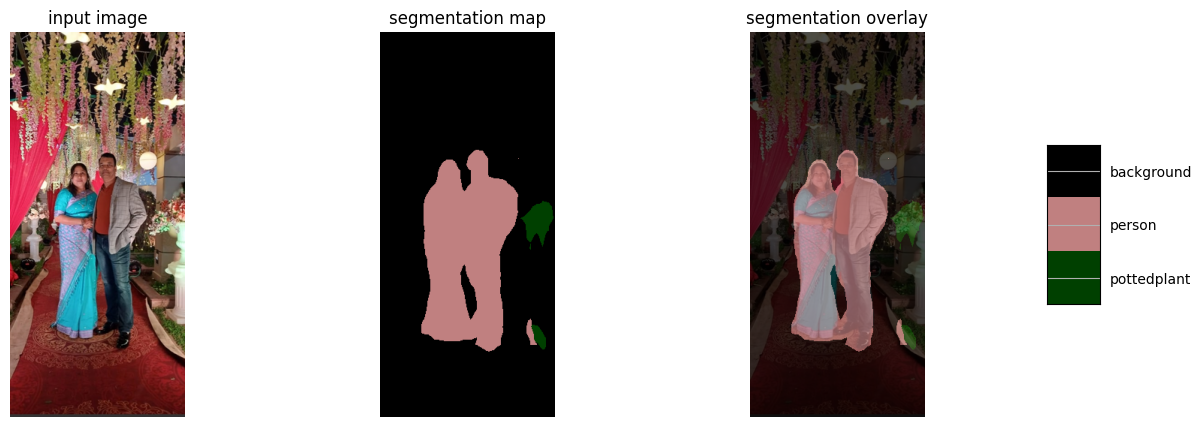

In [72]:
resized_im, seg_map = run_visualization() # Calling the above function.

In [73]:
LABEL_NAMES # Checking the label names.

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

In [74]:
print(type(resized_im))
numpy_image = np.array(resized_im) # Convert PIL image to numpy array.

<class 'PIL.Image.Image'>


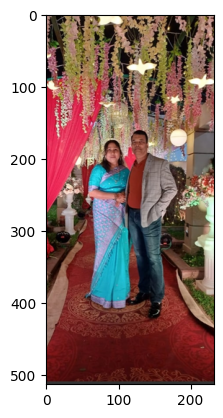

In [75]:
plt.imshow(numpy_image) # Checking the image.

In [76]:
person_not_person_mapping = deepcopy(numpy_image)  # Seperating background & foreground classes using Segmap.
person_not_person_mapping[seg_map != 15] = 0        # Replacing the pixel intensity values to 0 where the car class is not found in segmentation map  i.e changing background to balck.
person_not_person_mapping[seg_map == 15] = 255      # Replacing the pixel intensity values to 1 where the car calss is found in segmentation map i.e changing the foreground to white.


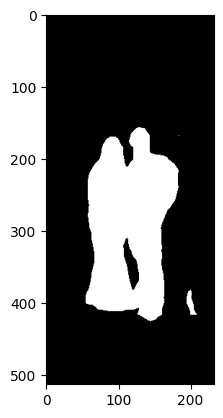

In [77]:
plt.imshow(person_not_person_mapping) # Ploting the mapped image.

In [78]:
np.unique(person_not_person_mapping)

array([  0, 255], dtype=uint8)

In [79]:
orig_imginal = Image.open(IMAGE_NAME) # Reading the original image.
orig_imginal = np.array(orig_imginal) # Converting the image to an numpy array.
orig_imginal.shape # Checking the dimensions of the original image.

(840, 383, 3)

In [80]:
mapping_resized = cv2.resize(person_not_person_mapping, # Resizing the mapped image to the original image size.
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

<ipython-input-80-2cdaca246d22>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


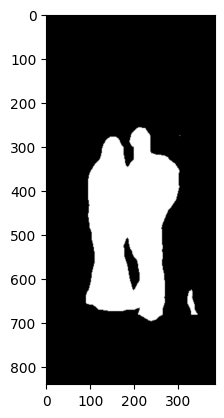

In [81]:
plt.imshow(mapping_resized) # Checking the resized image.

In [82]:
mapping_resized.shape

(840, 383, 3)

In [83]:
np.unique(mapping_resized) # After resizing image to original size it adds up additional pixel values ranging from 0 to 255.

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [84]:
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY) # Converting mapped image to gary.
blurred = cv2.GaussianBlur(gray,(15,15),0) # Applying the gaussin blur effect.
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Applying binarization based on Ots

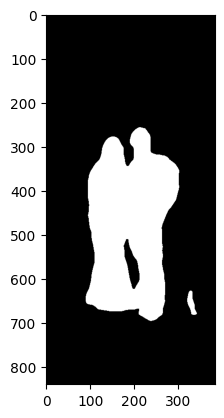

In [85]:
plt.imshow(thresholded_img, cmap="gray") # Plotting the binarized image.

In [86]:
thresholded_img.ndim # Checking the dimensions

2

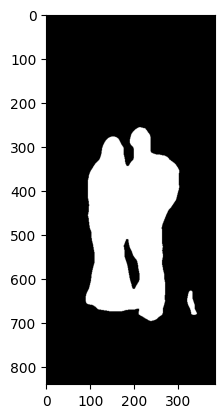

In [87]:
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB) # Applying or converting the throshold image to RGB space.
plt.imshow(mapping) # Plotting the image.

In [88]:
np.unique(mapping) # After applying the colors the pixel intensity  values are limited to 0 and 255 as per our segmented map.

array([  0, 255], dtype=uint8)

In [89]:
blurred_original_image = cv2.GaussianBlur(orig_imginal,
                                          (251,251),
                                          0)
# Applying blur effect to entire original image.

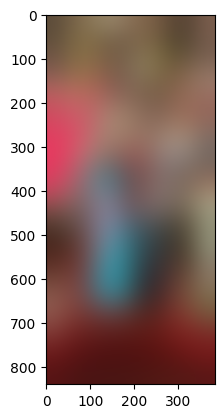

In [90]:
plt.imshow(blurred_original_image) # checking the blur image.

In [91]:
layered_image = np.where(mapping != (0,0,0),
                         orig_imginal,
                         blurred_original_image)
# The main part where we replace segmented map image where the pixel intensity values are not 0 i.e white with original image,
# and replace background where the pixel intensity values are 0 i.e balck with the blured image.

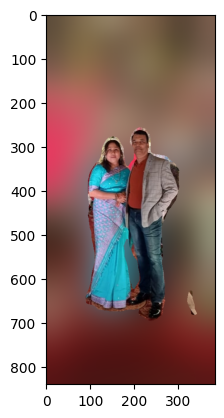

In [92]:
plt.imshow(layered_image) # Plotting the bokhe image.

In [93]:
im_rgb = cv2.cvtColor(layered_image, cv2.COLOR_BGR2RGB) # Saving the new bokeh image.
cv2.imwrite("Potrait_Image.jpg", im_rgb)

True

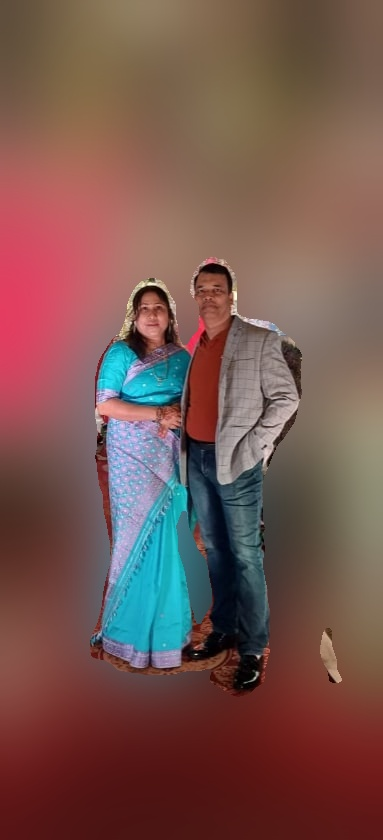

In [94]:
IMG("Potrait_Image.jpg") # Viewing the saved image in orginal size.